## Importing Libraries

In [43]:
from __future__ import print_function
from pprint import pprint
from time import time
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
%matplotlib inline
plt.style.use('bmh')

### Importing sklearn modules
___

In [2]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, confusion_matrix

### Preprocessing Data
___
This function preprocess our dataset:
- TF-IDF, is used to represent the importance of the words inside their context
- SPLIT, is used to split the dataset into two portions defined by RATIO of **training** and **testing**

In [5]:
def preprocess_data(data, vectorizer, ratio):
    X = vectorizer.fit_transform(data.data)
    return train_test_split(X, data.target, test_size=1-ratio, random_state=0)

### Coarse-to-fine approach for hyper parameters optimization
To find the best parameters is commonly used a coarse-to-fine approach.
We first start with a wide range of parameters and we refine them as we get closer to the best results.
___
We declare the parameters we want to optimize:
- More parameters =  better exploring power 
- Less parameters = decreasing processing time

In [3]:
def estimate_parameters(data, pipeline, parameters, n_jobs=-1, verbose=1, cv=10):
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=n_jobs, verbose=verbose, cv=cv)
    print('----------------------------------------')
    print("Cross validating with grid search for...")
    print([name for name, _ in pipeline.steps])
    print('----------------------------------------')
    print("Analyzed parameters:")
    pprint(parameters)
    print('----------------------------------------')
    t0 = time()
    grid_search.fit(data.data, data.target)
    print("Fine tuning took %0.3fs" % (time() - t0))
    print("Best obtained is score: %0.3f" % grid_search.best_score_)
    best_parameters = grid_search.best_estimator_.get_params()
    return best_parameters

### Training Random Forest classifier
___
We build the Random Forest classifier specifying:
- number of estimators
- maximum depth of the forest
We train the model and return the classifier

In [4]:
def train_random_forest(X_train, y_train, n_estimators, max_depth):
    rfc = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
    return rfc.fit(X_train, y_train)

### Plotting confusion matrix


In [75]:
def plot_confusion_matrix(cnf_matrix, class_names):
    norm_conf = []
    for i in cnf_matrix:
        a = 0
        tmp_arr = []
        a = sum(i, 0)
        for j in i:
            tmp_arr.append(float(j)/float(a))
        norm_conf.append(tmp_arr)
    fig = plt.figure(figsize=(16, 10))
    plt.clf()
    ax = fig.add_subplot(111)
    ax.set_aspect(1)
    res = ax.imshow(np.array(norm_conf), cmap=plt.cm.jet, 
                    interpolation='nearest')
    width, height = cnf_matrix.shape
    for x in range(width):
        for y in range(height):
            ax.annotate(str(cnf_matrix[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center')
    cb = fig.colorbar(res)
    plt.xticks(range(width), class_names, rotation=90)
    plt.ylabel('True Label')
    plt.xlabel('Prediction Label')
    plt.yticks(range(height), class_names)
    plt.savefig('confusion_matrix.png', format='png')

### Visualize importance of features and the distribution of the importance

In [32]:
def visualize_features_importance(classifier, n_features=100, y='Feature importance'):
    importances_feat = pd.DataFrame(classifier.feature_importances_)
    importances_feat.columns = [y]
    importances_feat = importances_feat.sort_values(y,ascending=False)
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=[16,10])
    plt.suptitle('Distribution of feature importance', x=0.5, y=1.00, ha='center', fontsize='xx-large')
    importances_feat.head(n_features).hist(ax=axes[0])
    importances_feat.head(n_features).plot(ax=axes[1],kind='bar', title='Importance of the features')

## Execution
___
Fetching dataset and preprocessing using the functions described above.

In [6]:
data = fetch_20newsgroups(subset='train')
vectorizer = TfidfVectorizer()
X_train, X_test, y_train, y_test = preprocess_data(data, vectorizer, 0.9)

#### Pipeline and Parameters declaration
___
- TfidfVectorizer is our TF-IDF vectorizer for the sentences
- RandomForestClassifier is the classifier we are training

In [7]:
# Define a Pipeline

pipeline = Pipeline([
    ('vect', TfidfVectorizer()),
    ('clf', RandomForestClassifier()),
])

parameters = {
    #'vect__max_df': (0.5, 0.75, 1.0),
    #'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    'clf__max_depth': (20, 30, 40),
    'clf__n_estimators': (1000, 1200),
}

### Parameters fine-tuning
___

In [8]:
best_parameters = estimate_parameters(data, pipeline, parameters)

Performing grid search...
pipeline: ['vect', 'clf']
parameters:
{'clf__max_depth': (20, 30, 40), 'clf__n_estimators': (1000, 1200)}
Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 14.9min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 32.3min finished


done in 2179.249s
Best score: 0.844


### Training

In [10]:
classifier = train_random_forest(X_train, y_train, 
                    best_parameters.get('clf__n_estimators'), 
                    best_parameters.get('clf__max_depth'))

### Testing

In [77]:
classifier.score(X_test, y_test)

0.83766578249336865

### Plotting confusion Matrix

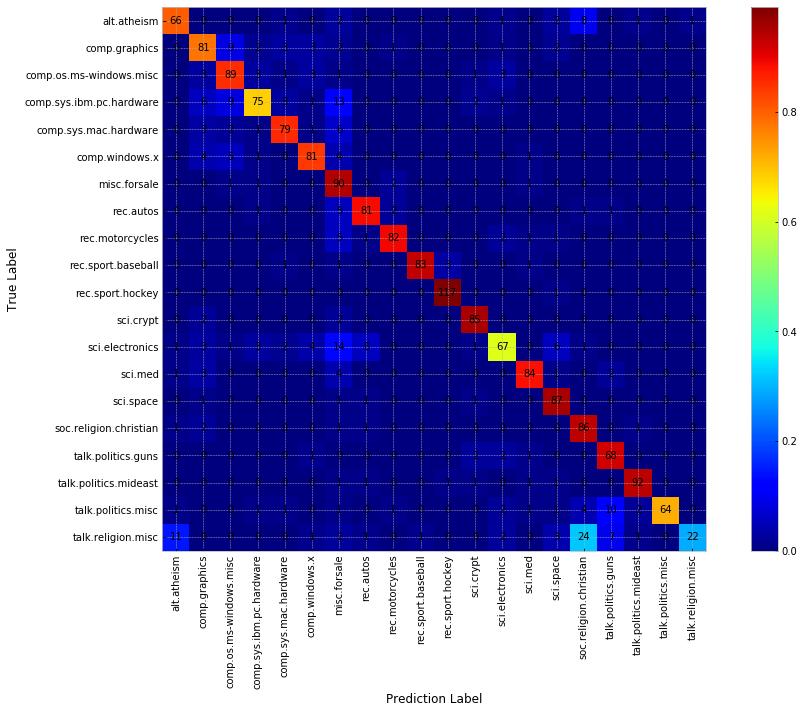

In [76]:
y_pred = classifier.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred)
class_names = data.target_names
plot_confusion_matrix(cnf_matrix, class_names)

#### Observations:
___
### Plotting features importance and distribution

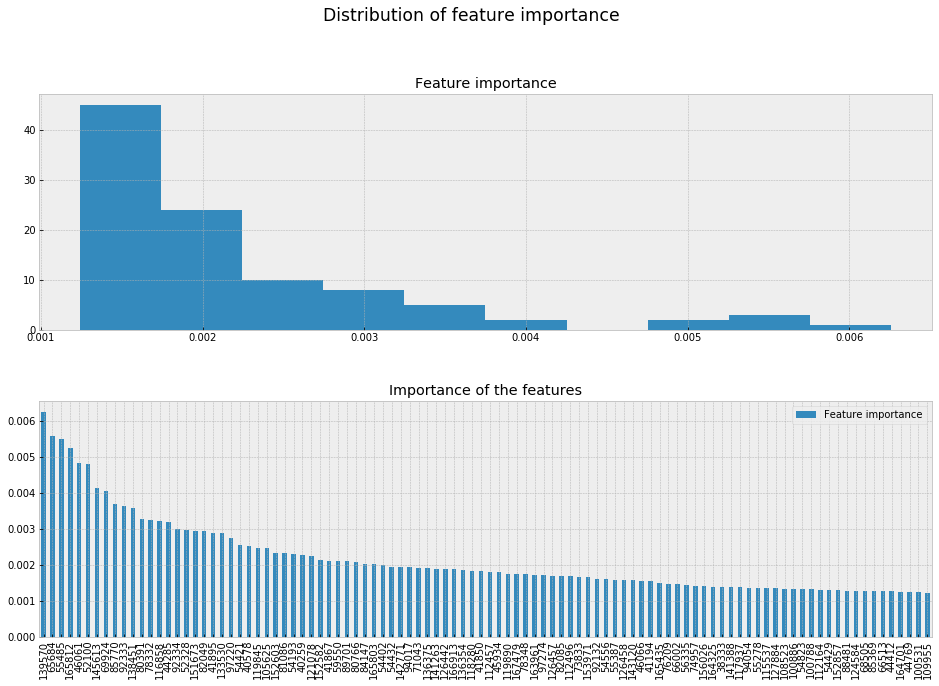

In [35]:
visualize_features_importance(classifier)

#### Observations: